In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random
rnd.seed(42) # Change seed value to randomise
from itertools import combinations 
norm = np.linalg.norm

# Functions for dual-decomposition 

In [17]:
def Min_Cost(c,I,Open):
    M = len(Open)
    k_q = Open[0]
    cost = c[I,k_q]
    for m in range(M):
        if c[I,Open[m]] < cost:
            cost = c[I,Open[m]]
            k_q = Open[m]
    return k_q, cost

def find_max(X):
    Return = []
    for x in X:
        if x<0:
            Return.append(0)
        else : 
            Return.append(x)
    return Return

def Rise_Value(UC,p):
    for uc in UC:
        p[uc] = p[uc] + 1

# Functions for primal-decomposition 

In [18]:
def Min_Cost_(c,I,unused_facilities,M):
    unsued = np.where(unused_facilities==1)
    cost = c[I,unsued[0][0]]
    k_q = unsued[0][0]
    for m in range(M):
        if unused_facilities[m] == 1:
            if c[I,m] < cost:
                cost = c[I,m]
                k_q = m 
    return k_q, cost
#--------------------------------------
def Projection(Y,M):
    for m in range(M):
        if Y[m]<0:
            Y[m] = 0
        elif Y[m]>1:
            Y[m] = 1            
#--------------------------------------
def find_open_facility(Y,M):
    OF = np.zeros(M)
    for m in range(M):
        if Y[m]>0:
            OF[m] = 1
    return OF
#--------------------------------------
def y_bigger_than_1(Y):
    M = len(Y)
    Sum = sum(Y)
    while(1-Sum > 0.0001):
        residual = (1 - Sum)/M
        for m in range(M):
            Y[m] += residual
        Projection(Y,M)
        Sum = sum(Y)     
#--------------------------------------
def recreate_open_facilities(Y,m):
    OF = np.zeros(m)
    Max = np.sort(Y)[-1]
    print(Max)
    for M in range(m):
        if Y[M] >= Max/5:
            OF[M] = 1
    return OF

# Functions for ADMM

In [19]:
def f_x(X,c,n):
    cost = 0
    for i in range(n):
        set_of_chosen_facilities = np.where(X[i]==1)[0]
        for f in set_of_chosen_facilities:
            cost += c[i,f]*X[i,f]
    return cost 
#------------------------------
def g(f,Y):
    L = len(Y)
    cost_f = 0
    for l in range(L):
        cost_f += Y[l]*f[l]
    return cost_f
#------------------------------
def L_P(X, c, f, Y, P, z_k, n, m):
    F = f(X,c,n)
    G = g(f,Y)
    Z = sum(Y) - 1
    Dot = z_k*Z
    Norm = P/2*norm(Z)
    return F + G + Dot + Norm
#--------------------------------------
def find_open_facility(Y,M):
    OF = np.zeros(M)
    for m in range(M):
        if Y[m]>0:
            OF[m] = 1
    return OF
#------------------------------
def find_x(Y,m,I):
    OF = find_open_facility(Y,m)
    assigned_facilities = {i: np.zeros(m) for i in I}
    for i in I:
        b = 1
        q = 0
        while(b != 0):
            unused_facilities = OF - assigned_facilities[i]
            if sum(unused_facilities) == 0:
                break
            k_q, c_ = Min_Cost_(c,i,unused_facilities,m)

            assigned_facilities[i][k_q] = 1
            x_k_q = min(b,Y[k_q])
            b -= x_k_q
            q += 1
    return assigned_facilities
#------------------------------
def find_gradien(m,OF,I,assigned_facilities,f,J):
    Eta = np.zeros(m)
    for i in I:
        unused_facilities = OF - assigned_facilities[i]
        if sum(unused_facilities) != 0 :
            _, min_cost = Min_Cost_(c,i,unused_facilities,m)
            for j in J:
                Beta = max(0,min_cost-c[i,j])
                Eta[j] = f[j] - Beta

    return Eta
#------------------------------
def find_z(z_k, P, Z):
    z_k_plus_1 = z_k + P*Z
    return z_k_plus_1
#------------------------------
def find_the_best_learning_rate(Y, Eta, f, z_k, P):
    L_P_values = []
    steps = np.linspace(0, 0.1, num=100)
    for step in steps:
        Y_new = Y - step*Eta
        G = g(f,Y_new)
        Z = sum(Y_new) - 1
        Dot = z_k*Z
        Norm = P/2*norm(Z)
        L_P_values.append(G + Dot + Norm)
    Min = np.argsort(L_P_values)[0]  
    return steps[Min]
#--------------------------------------
def cost_calculating(I,OF,m,f,c):
    OF_ = []   
    assigned_facilities_ = {i: [] for i in I}
    for i in I:
        k_q, _ = Min_Cost_(c,i,OF,m)
        assigned_facilities_[i].append(k_q)
        OF_.append(k_q)
    OF_ = np.unique(OF_)  
    #===================
    cost = 0
    for i in I:
        W = assigned_facilities_[i][0]
        cost += c[i,W]
    cost += Cost_2_open_F(OF_,f)
    return cost, assigned_facilities_, OF_

# Functions fo accelerated ADMM

In [20]:
def find_y_again(Y, z_k, Eta, f):
    L_P_values = []
    steps = np.linspace(0, 0.1, num=100)
    for step in steps:
        Y_new = Y - step*Eta
        G = g(f,Y_new)
        Z = sum(Y_new)
        L_P_values.append(G + np.maximum(z_k,-Z))
        Min = np.argsort(L_P_values)[0]  
    return steps[Min]

In [21]:
def Cost_2_open_F(Open,f):
    Cost = 0
    for o in Open:
        Cost += f[o]
    return Cost

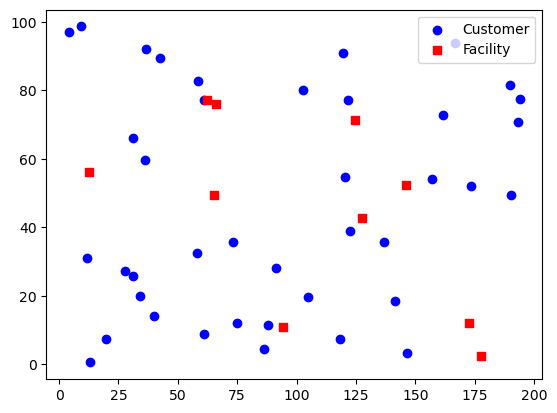

In [22]:
n = 40 # Number of Customer
xc = rnd.rand(n) * 200 # x-coordinate
yc = rnd.rand(n) * 100 # y-coordinate

m = 10  # Numebr of Facility
xf = rnd.rand(m) * 200 # x-coordiante 
yf = rnd.rand(m) * 100 # y-coordiante

plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer') # Customer
plt.scatter(xf[0:], yf[0:], c='r', marker='s', label = 'Facility') # Facility
plt.legend()
plt.show();

In [23]:
I = [i for i in range(0, n)] # Customer
J = [i for i in range(0, m)] # Facility
D = {i: rnd.randint(1, 10) for i in I} # Demand of Customer
A = [(i, j) for i in I for j in J] # 2-D cartesian product
f = {j: 100 for j in J} # Fixed setup cost of Facility
c = {(i, j): 1*np.hypot(xc[i]-xf[j], yc[i]-yf[j]) for (i, j) in A} # Cost to reach customer from Facility

# Without Optimization (Centralized) 

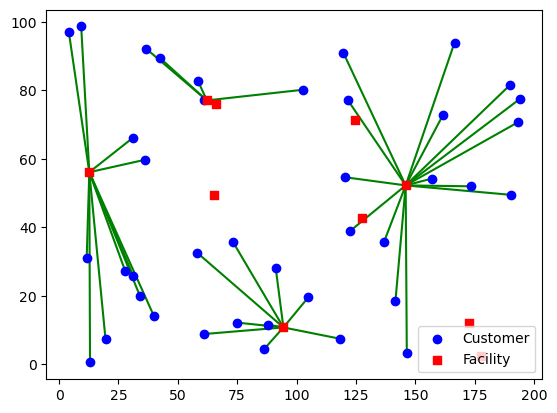

Total cost without considering contributions on all facilities =  1671.0264911404329
Number of open facilities = 4


In [25]:
comb_list = list()
for M in range(1,m+1):
    comb_list += list(combinations(range(0,m),M))
    
List_of_costs = []

k = 0
for Open_List in comb_list:
    Open_List = np.array(Open_List)
    cost_of_customers = 0
    which_is_used = []
    for i in I:
        k_q, cost = Min_Cost(c,i,Open_List)
        cost_of_customers += cost
        which_is_used.append(k_q)
    which_is_used = np.unique(which_is_used)
    List_of_costs.append(cost_of_customers + len(which_is_used)*100)
    k += 1   
#-------------

new_assigned_facilities = {i: [] for i in I}
Ind = np.argsort(List_of_costs)[0]
Open_List_ = np.array(comb_list[Ind])
cost_of_customers = 0
for i in I:
    k_q, cost = Min_Cost(c,i,Open_List_)
    cost_of_customers += cost
    new_assigned_facilities[i].append(k_q)
#-------------
for i in range(n):
    plt.plot([xc[i], xf[new_assigned_facilities[i][0]]], [yc[i], yf[new_assigned_facilities[i][0]]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();

print('Total cost without considering contributions on all facilities = ',List_of_costs[Ind])
print('Number of open facilities =', len(comb_list[Ind])) 

# Dual

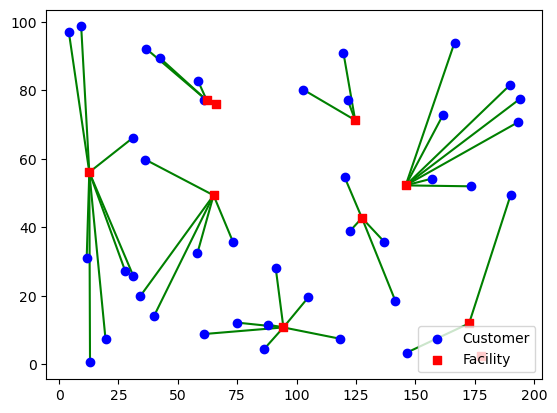

Total cost without considering contributions on all facilities =  1889.045310913484 $
Number of open facilities = 8


In [29]:
p = {i: 0 for i in I} #set p_i to zero
clients_status = {i: 0 for i in I}
open_facilities = {j: 0 for j in J}
assigned_facilities = {i: [] for i in I}
Contributions = {j: 0 for j in J} # the money for each F
Contribution_list = {i: [] for i in I} #clients contribution list
F_Contribution_list = {j: [] for j in J}# facilities contribution list
which_opens_first = []

flag = True
Times = 0
while(flag):
    unassigned_clients = np.where(np.array(list(clients_status.values()))==0)[0]

    Rise_Value(unassigned_clients,p)
    for M in range(m):
        
        
        difference = np.zeros(n)
        for uc in unassigned_clients:
            difference[uc] = p[uc] - c[uc,M]
        #-----------------    
        if open_facilities[M]==1:
            for uc in unassigned_clients:
                if difference[uc] >= 0:
                   
                    clients_status[uc] = 1
                    assigned_facilities[uc].append(M)
        #-----------------
        elif open_facilities[M] == 0:
            abs_diff = find_max(difference)
            
            Sum = 0
            for uc in unassigned_clients:
                Sum += abs_diff[uc] 
                if abs_diff[uc]>0:
                    Contribution_list[uc].append(M)
                    F_Contribution_list[M].append(uc)
            Contributions[M] += Sum

#             for uc in unassigned_clients:
#                 if difference[uc]>0:
#                     p[uc] -= abs_diff[uc]
                    
            if Contributions[M] >= f[M]:
                open_facilities[M] = 1
                which_opens_first.append(M)
                x = (F_Contribution_list[M])
                F_Contribution_list[M]= sorted(set(x), key=x.index)
                for uc in unassigned_clients:
                    if difference[uc] >= 0:
                        clients_status[uc] = 1
                        assigned_facilities[uc].append(M) 
        unassigned_clients = np.where(np.array(list(clients_status.values()))==0)[0]
        if len(unassigned_clients) == 0:
            flag = False
    Times += 1
for i in range(n):
    x = (Contribution_list[i])
    Contribution_list[i]= sorted(set(x), key=x.index)
    
    
new_assigned_facilities = {i: [] for i in I}
open_F = []
for i in I:
    flag = 0
    if flag == 0: 
        for o in which_opens_first :
            if p[i] > c[i,o]:
                new_assigned_facilities[i].append(o)
                open_F.append(o)
                #print(p[i],c[i,o],1,o,i)
                flag = 1  
                break
    if flag == 0: 
        for o in which_opens_first :
            if p[i] == c[i,o]:
                new_assigned_facilities[i].append(o)
                open_F.append(o)
                #print(p[i],c[i,o],2,o,i)
                flag = 1 
                break
    if flag == 0: 
        for o in which_opens_first :
            if 3*p[i] >= c[i,o]:
                new_assigned_facilities[i].append(o)
                open_F.append(o)
                #print(p[i],c[i,o],3,o,i)
                flag = 1 
                break
open_F = np.unique(open_F)  


for i in range(n):
    plt.plot([xc[i], xf[new_assigned_facilities[i][0]]], [yc[i], yf[new_assigned_facilities[i][0]]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();
#----------------
cost_dual = 0
for i in I:
    cost_dual += c[i,new_assigned_facilities[i][0]]
cost_dual += Cost_2_open_F(open_F,f)
print('Total cost without considering contributions on all facilities = ',cost_dual,'$')
print('Number of open facilities =', len(open_F)) 

# Primal

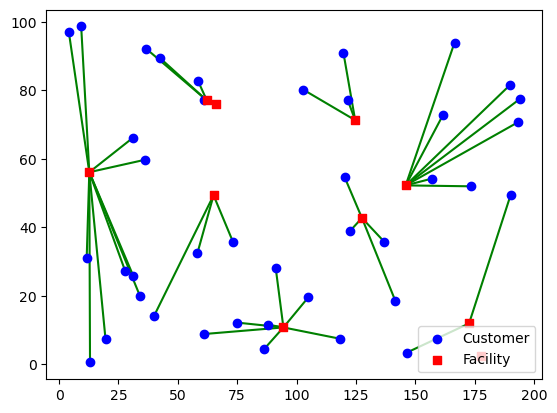

Total cost without considering contributions on all facilities =  1881.8252705827222
Number of open facilities = 8


In [31]:
Y = np.ones(m) #rnd.rand(m)  #open_facilities_values
Projection(Y,m)
OF = find_open_facility(Y,m) #open_facilities  

#print('Y = ',Y)

for k in range(1,100):
    assigned_facilities = {i: np.zeros(m) for i in I}
    #x_for_each_customer = {i: np.zeros(m) for i in I}
    Sum_of_clients = 0
    for i in I:
        b = 1
        q = 0
        #print('OF = ', OF)
        while(b != 0):
            unused_facilities = OF - assigned_facilities[i]
            #print(unused_facilities, i)
            if sum(unused_facilities) == 0:
                break
            k_q, c_ = Min_Cost_(c,i,unused_facilities,m)
            #print(i,k_q)
            assigned_facilities[i][k_q] = 1
            x_k_q = min(b,Y[k_q])
            #x_for_each_customer[i][k_q] = x_k_q
            Sum_of_clients += x_k_q*c_
            b -= x_k_q
            q += 1
    #---------------------------------------------------------
    Eta = np.zeros(m)
    for i in I:
        unused_facilities = OF - assigned_facilities[i]
        #print(unused_facilities)
        if sum(unused_facilities) != 0 :
            _, min_cost = Min_Cost_(c,i,unused_facilities,m)
            for j in J:
                Beta = max(0,min_cost-c[i,j])
                Eta[j] = f[j] - Beta
    #print('E:',Eta)
    if norm(Eta) != 0:
        step = 0.02*Sum_of_clients-cost_dual/(norm(Eta)+1) #0.001/np.sqrt(k)
        Y = Y - step*Eta 
        #print('Y =',Y)
        Projection(Y,m)

        y_bigger_than_1(Y)
        OF = find_open_facility(Y,m)   
        #print(Y)
    else:
        break

#OF_new = recreate_open_facilities(Y,m)
OF_ = []   
assigned_facilities_ = {i: [] for i in I}
for i in I:
    k_q, _ = Min_Cost_(c,i,OF,m)
    assigned_facilities_[i].append(k_q)
    OF_.append(k_q)
OF_ = np.unique(OF_)  
for i in range(n):
    W = assigned_facilities_[i][0]
    plt.plot([xc[i], xf[W]], [yc[i], yf[W]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();



cost = 0
for i in I:
    W = assigned_facilities_[i][0]
    cost += c[i,W]
cost += Cost_2_open_F(OF_,f)
print('Total cost without considering contributions on all facilities = ',cost)
print('Number of open facilities =', len(OF_)) 

# ADMM

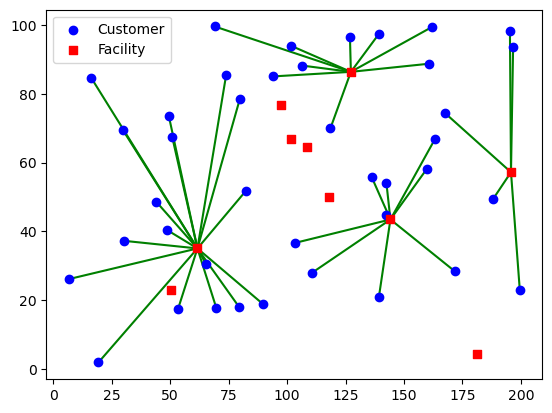

Total cost without considering contributions on all facilities =  1618.1255836849916
Number of open facilities = 4


In [25]:
#Initialization = []
OF_saving = []
cost_saving = []
for itr in range(10):    
    Y = rnd.rand(m)  #np.ones(m)  #open_facilities_values
    Projection(Y,m)
    #Initialization.append(Y)
    z_k = np.ones(m)
    OF = find_open_facility(Y,m) #open_facilities  
    P = 2
    for k in range(20):
        assigned_facilities = find_x(Y,m,I)
        OF = find_open_facility(Y,m)
        Eta = find_gradien(m,OF,I,assigned_facilities,f,J)
        step = find_the_best_learning_rate(Y, Eta, f, z_k, P)
        Y -= step*Eta
        Projection(Y,m)
        Z = sum(Y) - 1
        z_k = find_z(z_k, P, Z)
    OF_saving.append(OF)
    COST , _, __ = cost_calculating(I,OF,m,f,c)
    cost_saving.append(COST)
#---------------------------------
Min = np.argsort(cost_saving)[0]
OF_Min = OF_saving[Min]
cost ,assigned_facilities_, OF_  = cost_calculating(I,OF_Min,m,f,c)

for i in range(n):
    W = assigned_facilities_[i][0]
    plt.plot([xc[i], xf[W]], [yc[i], yf[W]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();
print('Total cost without considering contributions on all facilities = ',cost)
print('Number of open facilities =', len(OF_)) 

# Accelerated ADMM

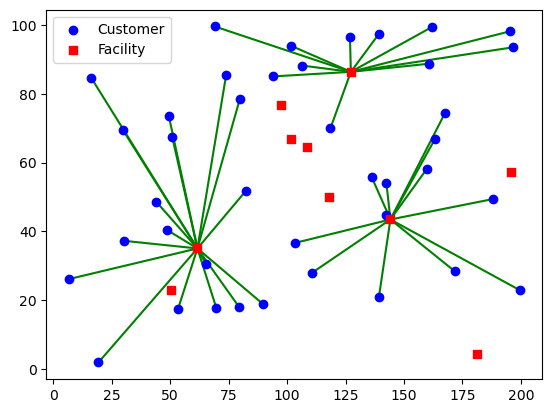

Total cost without considering contributions on all facilities =  1643.1919172516034
Number of open facilities = 3


In [28]:
#Initialization = []
OF_saving = []
cost_saving = []
for itr in range(10):    
    Y = rnd.rand(m)  #np.ones(m)  #open_facilities_values
    Projection(Y,m)
    #Initialization.append(Y)
    z_0 = np.zeros(m)
    z_k = np.ones(m)
    OF = find_open_facility(Y,m) #open_facilities  
    P = 2
    a = 1
    for k in range(20):
        assigned_facilities = find_x(Y,m,I)
        OF = find_open_facility(Y,m)
        Eta = find_gradien(m,OF,I,assigned_facilities,f,J)
        step = find_the_best_learning_rate(Y, Eta, f, z_k, P)
        Y -= step*Eta
        Projection(Y,m)
        
        Z = sum(Y) - 1
        z_k_1 = find_z(z_k, P, Z)
        
        
        a = (1+np.sqrt(1+4*a**2))/2
        z_k = z_k_1 + (a-1)/(a+1)*(z_k_1-z_0)
        z_0 = z_k_1
        
        Eta = find_gradien(m,OF,I,assigned_facilities,f,J)
        step = find_y_again(Y, z_k, Eta, f)
        Y -= step*Eta
        Projection(Y,m)
        
    OF_saving.append(OF)
    COST , _, __ = cost_calculating(I,OF,m,f,c)
    cost_saving.append(COST)
#---------------------------------
Min = np.argsort(cost_saving)[0]
OF_Min = OF_saving[Min]
cost ,assigned_facilities_, OF_  = cost_calculating(I,OF_Min,m,f,c)

for i in range(n):
    W = assigned_facilities_[i][0]
    plt.plot([xc[i], xf[W]], [yc[i], yf[W]], c='g', zorder=0)
plt.scatter(xc[0:], yc[0:], c='b', label = 'Customer')
plt.scatter(xf[0:], yf[0:], c='r',marker='s', label = 'Facility')
plt.legend()
plt.show();
print('Total cost without considering contributions on all facilities = ',cost)
print('Number of open facilities =', len(OF_)) 